In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from focal_loss import BinaryFocalLoss

tf.config.threading.set_intra_op_parallelism_threads(10) 
tf.config.threading.set_inter_op_parallelism_threads(10) 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 1 Logical GPU


Hyper parameters

In [2]:
# RESULTS_FOLDER = 'thesis_experiments/nr_train_layers_512bs_20epochs/3_70layers_algo_20classes_EfficientNetB2'

def get_config(class_weights, augment, rus, 
               data_folder='data/split_dataframes_heuristic_labels_20221006', 
               epochs=15, basemodel='EfficientNetB2', nr_classes=20, batch_size=512, 
               loss_function='binary_crossentropy', image_dimension=64):
    config = {}
    config['epochs'] = epochs
    config['basemodel'] = basemodel
    config['nr_classes'] = nr_classes
    config['batch_size'] = batch_size
    config['data_folder'] = data_folder
    config['loss_function'] = loss_function
    config['class_weights'] = class_weights
    config['image_dimension'] = image_dimension
    results_folder = f'thesis_experiments/'
    results_folder += '_class_weights_' if class_weights == True else ''
    results_folder += '_augment_' if augment == True else ''
    results_folder += '_rus_' if rus == True else ''
    results_folder += f'_bs_${batch_size}'
    config['results_folder'] = results_folder
    return config

config = get_config(class_weights=False, augment=False, rus=True)
print(config)

{'epochs': 15, 'basemodel': 'EfficientNetB2', 'nr_classes': 20, 'batch_size': 512, 'data_folder': 'data/split_dataframes_heuristic_labels_20221006', 'loss_function': 'binary_crossentropy', 'class_weights': False, 'image_dimension': 64, 'results_folder': 'thesis_experiments/_rus__bs_$512'}


Loading datasets and augmentation

In [3]:
# train = hf.get_flow(df_file=config['data_folder'] + '/train_df.json.bz2',
#                    nr_classes=config['nr_classes'],
#                    image_dimension=config['image_dimension'])
# df = pd.read_json(config['data_folder'] + '/val_stop_df.json.bz2', compression='bz2')
val_stop = hf.get_flow(df_file=config['data_folder'] + '/val_stop_df.json.bz2',
                       nr_classes=config['nr_classes'],
                       image_dimension=config['image_dimension'])

# name_id_map = train.class_indices
# class_names = len(name_id_map)*[0]
# for k in name_id_map.keys():
#     class_names[name_id_map[k]] = k

Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.


Random undersampling

Unweighted mean imbalance ratio: 40.97
Unweighted mean imbalance ratio: 32.65
Could not save image


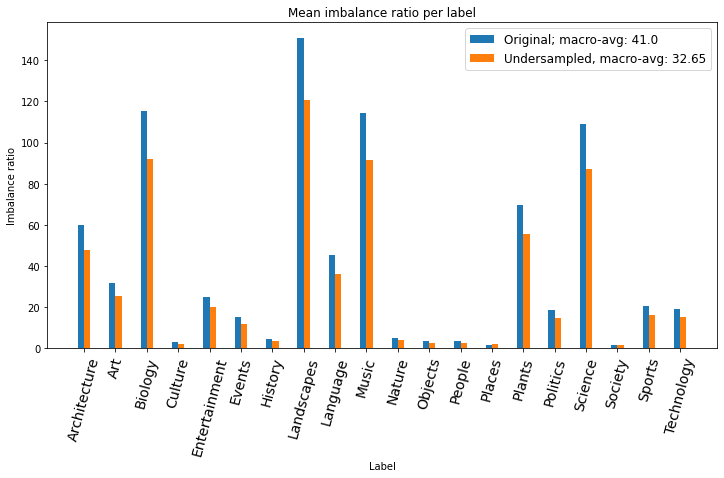

In [4]:
y_true = hf.get_y_true(shape=(val_stop.samples, len(val_stop.class_indices)), classes=val_stop.classes)

# Get indices to remove
indices_to_remove = hf.undersample(y_true, list(val_stop.class_indices.keys()), 0.8,  config['results_folder'])

In [13]:
label_names = list(val_stop.class_indices.keys())
kept_pctg = 0.8
ir_original = hf.imbalance_ratio(y_true=y_true, class_names=label_names)
def remove_row(array, label_costs, row_costs, random=False):
    """
    Remove the row with the minimal cost (or just a random row containing the currently
    most common class).
    Output:
        - tuple containing the index of the removed row (i.e. image), and the updated row and label costs.
    """
    # Select and remove the row with minimal cost
    row_idx = np.argmin(row_costs)
    # Update label_costs and row_costs for the next iteration
    label_costs -= row_costs[row_idx] 
    row_costs = np.delete(row_costs, row_idx)
    return row_idx, label_costs, row_costs

original_nr_rows = y_true.shape[0]
y_true_copy = np.copy(y_true)
indices_to_remove = []

BIG_NUMBER = 40_000
label_costs = BIG_NUMBER / y_true_copy.sum(axis=0)
row_costs = row_costs = (label_costs * y_true_copy).sum(axis=1)


while y_true_copy.shape[0] > original_nr_rows * kept_pctg:
    (row_idx, label_costs, row_costs) = remove_row(y_true_copy, label_costs, row_costs)
    # All indices of rows in y_true that match with the removed row.
    matching_indices_to_remove = np.where((y_true == y_true_copy[row_idx]).all(axis=1))[0]
    y_true_copy = np.delete(y_true_copy, row_idx, axis=0)
    # Below, take the indices which have not been already added to indices_to_remove
    idx_to_remove = np.setdiff1d(matching_indices_to_remove, indices_to_remove)[0]
    indices_to_remove.append(idx_to_remove)
ir_heuristics = hf.imbalance_ratio(y_true=y_true_copy, class_names=label_names)

Unweighted mean imbalance ratio: 40.97
Unweighted mean imbalance ratio: 32.65


In [10]:
# Remove these indices from dataframe
undersample = True
if undersample:
    val_stop_df = pd.read_json(config['data_folder'] + '/val_stop_df.json.bz2', compression='bz2')
    balanced_df = val_stop_df.reset_index().drop(index=indices_to_remove)
# Get flow for this new more balanced dataframe

# Train


In [5]:
model = hf.create_model(n_labels=config['nr_classes'], 
                        image_dimension=config['image_dimension'],
                        model_name=config['basemodel'], 
                        number_trainable_layers=config['number_trainable_layers'])


Number of layers in basemodel: 339
Number of trainable layers: 70

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               721024    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 8,492,173
Trainable params: 5,722,684
Non-trainable params: 2,769,489
_________________________________________________________________


Train model

In [6]:
# ===================== TRAIN MODEL ==================
# Save model in between epochs
checkpoint_path = config['results_and_checkpoints_folder'] + "/cp-{epoch:04d}.ckpt"
print(checkpoint_path)
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 save_weights_only=True,
                                                 verbose=1)
history_callback = tf.keras.callbacks.CSVLogger(f"{config['results_and_checkpoints_folder']}/history.csv", 
                                                separator=',', 
                                                append=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           min_delta=0,
                                                           patience=3,
                                                           verbose=0,
                                                           mode='auto',
                                                           restore_best_weights=True)
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

if config['class_weights'] == True:
    # Calculate class weights: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
    weights = train_df[["labels", "title"]].explode("labels")\
            .groupby("labels").agg("count").reset_index()
    total = weights.title.sum()
    weights['proportion'] = weights.title.apply(lambda r: r/total)
    weights['weight'] = weights.title.apply(lambda r: (1/r)*(total/41)) # 
    # weights['weight'] = weights.page_title.apply(lambda r: np.log((1/r)*(total/2)))
    weights = weights[['labels', 'proportion', 'weight']]
    class_weight={}
    for l in name_id_map.keys():
        w = weights[weights.labels==l].weight.iloc[0]
        class_weight[train_generator.class_indices[l]] = w
    history = model.fit(
    train_generator,
    verbose=2,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[cp_callback, history_callback, early_stopping_callback],
    class_weight=class_weight)

else:
    history = model.fit(
    train_generator,
    verbose=2,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[cp_callback, history_callback, early_stopping_callback])
# ======================================================

Plot training metrics

In [8]:
# ================= PLOT TRAINING METRICS ==============
def plot_training_metrics():
    "Plot training metrics: loss & accuracy"
    training_metrics = pd.read_csv(config['results_and_checkpoints_folder'] + '/history.csv')

    epochs = training_metrics.shape[0]

    acc = training_metrics.accuracy.values
    loss = training_metrics.loss.values

    val_acc = training_metrics.val_accuracy.values
    val_loss = training_metrics.val_loss.values

    _ = plt.figure(figsize=(12, 4))
    _ = plt.subplot(1, 3, 1)
    _ = plt.plot(range(epochs), acc, label='Training Accuracy')
    _ = plt.plot(range(epochs), val_acc, label='Validation Accuracy')
    _ = plt.legend(loc='lower right')
    _ = plt.title('Training and Validation Accuracy')

    _ = plt.subplot(1, 3, 2)
    _ = plt.plot(range(epochs), loss, label='Training Loss')
    _ = plt.legend(loc='upper right')
    _ = plt.title('Training Loss')

    _ = plt.subplot(1, 3, 3)
    _ = plt.plot(range(epochs), val_loss, label='Validation Loss', color='orange')
    _ = plt.legend(loc='upper right')
    _ = plt.title('Validation Loss')
    _ = plt.savefig(config['results_and_checkpoints_folder'] + '/training_metrics.png')
# plot_training_metrics()

#### Visualize images from these labels

<ipython-input-185-be55bc3b022b>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)


UnicodeEncodeError: 'latin-1' codec can't encode character '\u0117' in position 49: ordinal not in range(256)

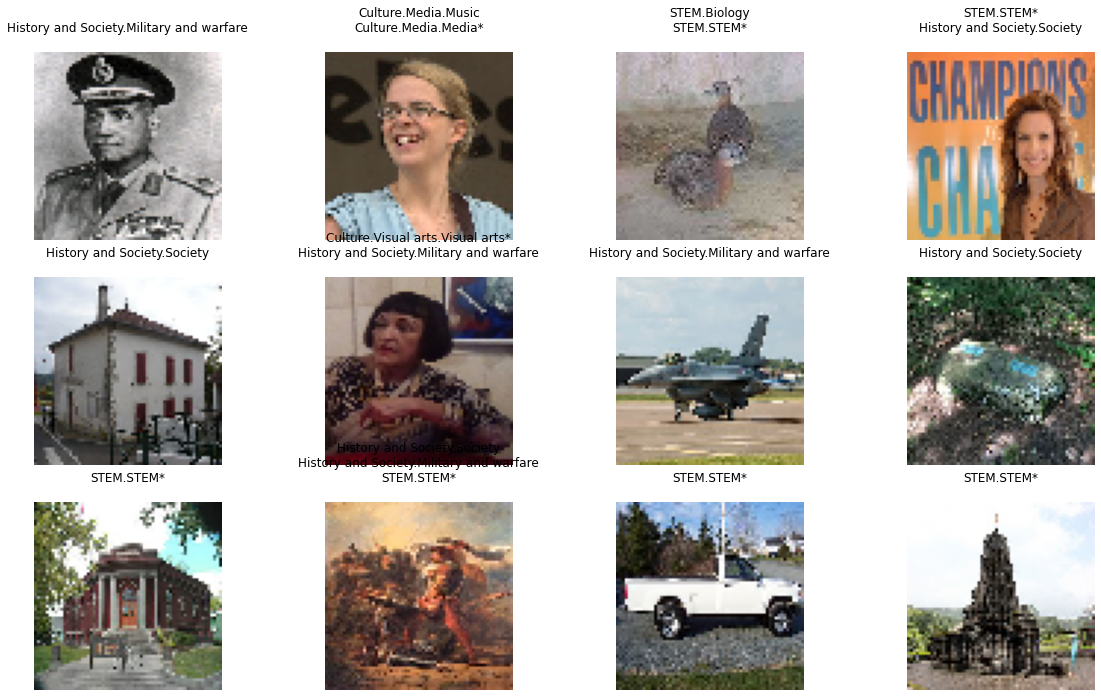

In [185]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(20, 20))
IMAGE_DIMENSION = 64
columns = 4
rows = 4
random_indices = np.random.randint(low=0, high=1e5, size=(rows,columns))
for i, idx in enumerate(random_indices.flatten()):
    path = '/scratch/WIT_Dataset/images/' + training_set_x_labels.iloc[idx, :].image_path
    img = load_img(path, target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))
    plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = ''.join([label + '\n' for label in training_set_x_labels.iloc[idx, :].labels])
    plt.title(title)
plt.suptitle('Some images and their ground truths')